In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torch.nn import init
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
import math

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline
use_cuda = torch.cuda.is_available()
# Load in data
data_string = 'lorAtt_20'
with open('lorAttData/%s.pickle' % (data_string), 'rb') as f: #Eventually take the file name as an argument
    data = pickle.load(f)
    
# Partition Data into Training, Validation, and Test sets (80/10/10)
random.seed(12345) # Comment out to get a different split every time
random.shuffle(data)
training = data[:(len(data)/10 * 8)]
val = data[(len(data)/10 * 8):(len(data)/10 * 9)]
test = data[(len(data)/10 * 9):]
print(len(data), len(training), len(val), len(test))

(10000, 8000, 1000, 1000)


In [4]:
# Convert to torch Tensors
for i in range(len(training)):
    training[i] = torch.FloatTensor(training[i])
for i in range(len(val)):
    val[i] = torch.FloatTensor(val[i])
for i in range(len(test)):
    test[i] = torch.FloatTensor(test[i])
print(training[0].size(), type(training[0]))

(torch.Size([20, 1, 3]), <class 'torch.FloatTensor'>)


In [5]:
# Define model
weight_std = math.sqrt(0.005) # Need to choose the set of std's
                 # Deep information Propagation paper uses sigma^2 = {1, 1.5, 2, 2.5, 3, 3.5, 4}
                 # simga_w^2 > 0.2 causes the model to diverge, so lets pick values under that: {0.03,0.06,0.09,0.12,0.15}
                 # Also uses sigma_bias^2 = 0.05
weight_mean = 0.0
bias_mean = 0.0
bias_std = math.sqrt(0.05)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        #self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
        for m in self.modules():
                if isinstance(m, torch.nn.Linear):
                    m.weight.data.normal_(weight_mean, weight_std)
                    m.bias.data.normal_(bias_mean, bias_std)
        
    def forward(self, input, hidden):
        combined = torch.cat([input, hidden], 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size)) # if use_cuda else Variable(torch.zeros(1,self.hidden_size))
    
hidden_features = 128
n_dim = training[0].size()[2]

encoderRNN = RNN(n_dim, hidden_features, n_dim)
decoderRNN = RNN(n_dim, hidden_features, n_dim)

# encoderRNN = encoderRNN.cuda() #if use_cuda
# decoderRNN = decoderRNN.cuda() #if use_cuda
print(encoderRNN, decoderRNN)

(RNN (
  (i2h): Linear (131 -> 128)
  (i2o): Linear (131 -> 3)
), RNN (
  (i2h): Linear (131 -> 128)
  (i2o): Linear (131 -> 3)
))


In [6]:
# Define Loss function and learning rate and size of input sequence
criterion = nn.MSELoss(size_average = True).cuda()
learning_rate = 0.005
input_sequence_length = 9
encoder_optimizer = optim.SGD(encoderRNN.parameters(), lr = learning_rate)
decoder_optimizer = optim.SGD(decoderRNN.parameters(), lr = learning_rate)
batch_size = 4

def train(input_batch):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    for c in range(batch_size):
        input_traj = input_batch[c]
        hidden = encoderRNN.initHidden()
        input_traj = Variable(input_traj) # if use_cuda else Variable(input_circle)


        output_sequence_length = input_traj.size()[0] - input_sequence_length

        encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) #if use_cuda else encoderOutput
        decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim)) #if use_cuda else decoderOutput

        # Run the training sequence into the encoder
        for i in range(input_sequence_length):
            encoderOutput[i], hidden = encoderRNN(input_traj[i], hidden)

        # Now the last hidden state of the encoder is the first hidden state of the decoder.
        # For now, let's have the first input be the origin
        for i in range(output_sequence_length):
            if (i == 0):
                dummyState = Variable(torch.zeros(1,n_dim)) # if use_cuda else Variable(torch.zeros(1,n_dim))
                decoderOutput[i], hidden = decoderRNN(dummyState, hidden)
            else:
                decoderOutput[i], hidden = decoderRNN(decoderOutput[i-1], hidden)

        # Loss is calculated only on the decoder output
        loss += criterion(decoderOutput, input_traj[-(output_sequence_length):]) #.cuda())

    loss /= batch_size
    loss.backward()
    # Update parameters
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0]

# Function for evaluating on validation and test sets
def evaluate(input_traj):
    hidden = encoderRNN.initHidden()
    input_traj = Variable(input_traj) # if use_cuda else Variable(circle)    

    output_sequence_length = input_traj.size()[0] - input_sequence_length
    
    encoderOutput = Variable(torch.zeros(input_sequence_length, 1, n_dim)) #if use_cuda else encoderOutput
    decoderOutput = Variable(torch.zeros(output_sequence_length,1, n_dim)) #if use_cuda else decoderOutput
    
    # Run the point sequence into the encoder
    for i in range(input_sequence_length):
        encoderOutput[i], hidden = encoderRNN(input_traj[i], hidden)
    
    # Now the last hidden state of the encoder is the first hidden state of the decoder. (whats the input to the first)
    # For now, let's have the first input be the origin
    for i in range(output_sequence_length):
        if (i == 0):
            dummyState = Variable(torch.zeros(1,n_dim)) # if use_cuda else Variable(torch.zeros(1,n_dim))
            decoderOutput[i], hidden = decoderRNN(dummyState, hidden)
        else:
            decoderOutput[i], hidden = decoderRNN(decoderOutput[i-1], hidden)
    
    loss = criterion(decoderOutput, input_traj[-(output_sequence_length):]) #.cuda())
    return decoderOutput, loss.data[0]

Finished epoch [1 / 10]  with training loss 0.03339 and validation loss 0.01197
0m 43s
Finished epoch [2 / 10]  with training loss 0.009253 and validation loss 0.008394
1m 26s
Finished epoch [3 / 10]  with training loss 0.007786 and validation loss 0.00764
2m 10s
Finished epoch [4 / 10]  with training loss 0.007235 and validation loss 0.007219
2m 53s
Finished epoch [5 / 10]  with training loss 0.006859 and validation loss 0.006899
3m 38s
Finished epoch [6 / 10]  with training loss 0.006545 and validation loss 0.006614
4m 24s
Finished epoch [7 / 10]  with training loss 0.006256 and validation loss 0.006347
5m 9s
Finished epoch [8 / 10]  with training loss 0.005988 and validation loss 0.006102
5m 54s
Finished epoch [9 / 10]  with training loss 0.005753 and validation loss 0.005898
6m 38s
Finished epoch [10 / 10]  with training loss 0.005566 and validation loss 0.00574
7m 23s


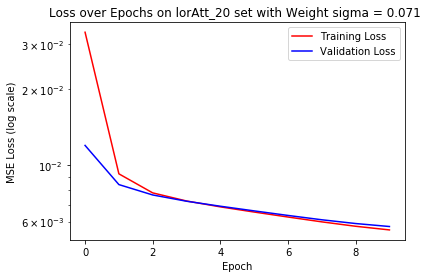

In [7]:
# Now, we are ready to train the model. Define some functions to help with plotting:
import time
import copy

n_epochs = 10
current_loss_train = 0
current_loss_val = 0
all_losses_train = []
all_losses_val = []
earlyStoppingCriteria = 7.5

# Keep track of losses from plotting

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m,s)

start = time.time()

for ep in range(n_epochs):
    n_batches = len(training)/batch_size
    for i in range(n_batches):
        loss = train(training[i*batch_size:((i+1)*batch_size)])
        current_loss_train += loss/n_batches


    for c in range(len(val)):
        pts, loss = evaluate(val[c])
        current_loss_val += loss/len(val)
    #Early Stopping

    # Method 2: Stop if Generalization Loss > 10% (see Automatic Early Stopping Using Cross Validation: Quantifying the Criteria by
    # Lutz Prechelt)
#     if ((ep != 0)):
#         if (current_loss_val/len(val) <= min(all_losses_val)):
#             print("New min at epoch %d" %(ep+1))
#             bestEncoder = copy.deepcopy(encoderRNN)
#             bestDecoder = copy.deepcopy(decoderRNN)
#         gLoss = current_loss_val/len(val) * (1/min(all_losses_val)) * 100 - 100
#         print("Generalization Loss at Epoch %d is %.3g" % (ep + 1, gLoss))
#         if (gLoss > earlyStoppingCriteria):
#             print("Stopping Early on epoch %g" % (ep+1))
#             print("Validation loss was %.4g" % (current_loss_val/len(val)))
#             encoderRNN = bestEncoder
#             decoderRNN = bestDecoder
#             break
        
    all_losses_train.append(current_loss_train)
    current_loss_train = 0
    all_losses_val.append(current_loss_val)
    current_loss_val = 0
    print("Finished epoch [%d / %d]  with training loss %.4g and validation loss %.4g" % (ep + 1, n_epochs,
                                                                                         all_losses_train[ep],
                                                                                          all_losses_val[ep]) )
    print(timeSince(start))




plt.plot(all_losses_train, 'r', label="Training Loss")
plt.plot(all_losses_val, 'b', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.yscale('log')
plt.title('Loss over Epochs on %s set with Weight sigma = %.3f ' % (data_string, weight_std))
plt.legend()
#plt.savefig('circlePlots/loss_data_%s_wsd2_%.3f.png' % (data_string, math.pow(weight_std,2)))
plt.show()

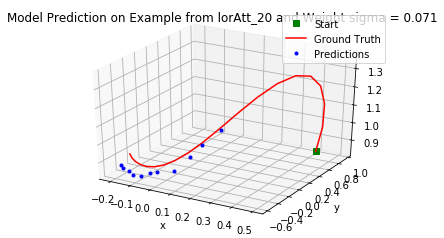

In [8]:
from mpl_toolkits.mplot3d import Axes3D
testTraj = test[random.randint(0,len(test))]
start_traj = testTraj.cpu().numpy()
points, loss = evaluate(testTraj)
end_traj = points.data.numpy()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(start_traj[0:1,0,0], start_traj[0:1,0,1], start_traj[0:1,0,2], 'gs', label='Start')
ax.plot(start_traj[:,0,0], start_traj[:,0,1], start_traj[:,0,2], 'r', label='Ground Truth')
ax.plot(end_traj[:,0,0], end_traj[:,0,1], end_traj[:,0,2], 'b.', label='Predictions')
# plt.plot(start_traj[:,0,0], start_traj[:,0,1], 'rs', label='Target Points')
# plt.plot(end_circle[:,0,0], end_circle[:,0,1], 'b.', label='Predicted Points')
plt.legend()
plt.title("Model Prediction on Example from %s and Weight sigma = %.3f" %(data_string, weight_std))
plt.xlabel('x')
plt.ylabel('y')
#plt.axes().set_aspect('equal', 'datalim')
#plt.savefig('circlePlots/vis_data_%s_wsd2_%.3f.png' % (data_string, math.pow(weight_std,2))
plt.show()         

In [9]:
# Store the model somewhere
#torch.save(encoderRNN.state_dict(), 'circleModel/%s_encoder_wsd2_%.3f' % (data_string,  math.pow(weight_std,2))
#torch.save(decoderRNN.state_dict(), 'circleModel/%s_decoder_wsd2_%.3f' % (data_string,  math.pow(weight_std,2))

In [ ]:
plt.plot(all_losses_train[10:30], 'r', label="Training Loss")
plt.plot(all_losses_val[10:30], 'b', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.yscale('log')
plt.title('Loss over Epochs on %s set with Weight sigma = %.3f ' % (data_string, weight_std))
plt.legend()
#plt.savefig('circlePlots/loss_data_%s_wsd2_%.3f.png' % (data_string, math.pow(weight_std,2)))
plt.show()

In [ ]:
for m in encoderRNN.modules():
    if isinstance(m, torch.nn.Linear):
        temp = m.weight.data.numpy()
        print(np.amax(temp))
#         temp = temp/np.amax(temp)
        temp = temp.reshape(temp.size,1)
        n, bins, patches = plt.hist(temp, 50, normed = 1)
        plt.show()        